In [110]:
#-*-coding:utf-8-*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import  preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#一个属性一个属性的探索以及处理
#通过explore探测到具体的数值属性以及缺省值属性以及字符属性
#题意上给出了such as women, children, and the upper-class 也就是等级，年龄，性别非常相关
#同时探索到std变换较大的是age和Fare属性

#Pclass
#explore后可能等级越高获救的可能性越大
#但是不能确定是否一定所以我们用虚拟化来处理one-hot_encoder相当于
#最后剩下Pclass-scaled
def processPclass(df):
    df.Pclass[df.Pclass.isnull()] = df.Pclass.dropna().mode().values
    dummies_df = pd.get_dummies(df['Pclass'],prefix='Pclass')#前缀
    df = pd.concat([df,dummies_df],axis=1)
    scaler = preprocessing.StandardScaler()
    df['Pclass_scaled'] = scaler.fit_transform(df['Pclass'])
    return df

#Name属性
#提到的关键属性有年龄性别，等级 均有说明整个属性比较重要
#长度长说明这个人可能地位高
#字符类型可能需要离散化或者虚拟化
#由于属性需要取值种类太多。我们将所有替换为几个关键的属性

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring)!=-1:
            return substring
    return np.nan

#替换规则
#若只跟某几个名字有关那么我们需要虚拟化扩维
def replace_titles(x):
    title = x['Title']
    if title in ['Mr', 'Don', 'Major', 'Capt', 'Sir', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Jonkheer']:
        return 'Master'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if x['Sex'] == 'male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title == '':
        if x['Sex'] == 'male':
            return 'Master'
        else:
            return 'Miss'
    else:
        return title
from  sklearn  import preprocessing
le = preprocessing.LabelEncoder()
def processName(df):
    df['Names'] = df['Name'].map(lambda x: len(re.split(' ', x)))  # 这个名字有几个词也就是长度
    df['Title'] = df['Name'].map(lambda x: re.compile(",(.*?)\.").findall(x)[0])#其中第一个.是任意字符
    #df['Title'] = df.apply(replace_titles,axis=1)
    df['Title'] = df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

    # group low-occuring, related titles together
    df['Title'][df.Title == 'Jonkheer'] = 'Master'
    df['Title'][df.Title.isin(['Ms', 'Mlle'])] = 'Miss'
    df['Title'][df.Title == 'Mme'] = 'Mrs'
    df['Title'][df.Title.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
    df['Title'][df.Title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'

    #虚拟化只跟某几种有关
    df = pd.concat([df,pd.get_dummies(df['Title']).rename(columns=lambda x:'Title_'+str(x))],axis=1)

    # #字符类型离散化
    # le.fit(df['Title'])
    # title_le = le.transform(df['Title'])
    # df['Title_id'] = title_le.astype(np.int32)
    df['Title_id'] = pd.factorize(df['Title'])[0]+1

    #标准化是为了后续组合特征以及PCA等
    scaler = preprocessing.StandardScaler()
    df['Names_scaled'] = scaler.fit_transform(df['Names'])
    scaler.fit(df['Title_id'])
    df['Title_id_scaled'] = scaler.transform(df['Title_id'])
    return df


#Sex属性
#探索后发现女性存活率高大概百分之75左右所以是关键属性
#文本-》数值 由于男女有区别所有转换成数值就行了
def processSex(df):
    df['Gender'] = df['Sex'].map({'female':0,'male':1}).astype(np.int32)
    return df


#Age属性
#std变换较大。缺省值有
#20-30最多人然后小孩第二多。最少的是老人
#小孩获救以及老人获救几率较高。其他差不多一般左右

def setMissingData(df,features=[],missFeature='Age'):
    feature_df = df[features]
    X = feature_df[df[missFeature].notnull()].as_matrix()[:,1::]
    y = feature_df[df[missFeature].notnull()].as_matrix()[:,0]
    rtr = RandomForestRegressor(n_estimators=2000,n_jobs=-1)#无限制处理机
    rtr.fit(X,y)
    predicitedAges = rtr.predict(feature_df[df[missFeature].isnull()].as_matrix()[:,1:])
    df.loc[(df[missFeature].isnull()),missFeature] = predicitedAges
    return df

# def setMissingAges(df):
#
#     age_df = df[['Age', 'Embarked', 'Fare', 'Parch', 'SibSp', 'Title_id', 'Pclass', 'Names', 'CabinLetter']]
#     X = age_df.loc[(df.Age.notnull())].values[:, 1::]
#     y = age_df.loc[(df.Age.notnull())].values[:, 0]
#
#     rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
#     rtr.fit(X, y)
#
#     predictedAges = rtr.predict(age_df.loc[(df.Age.isnull())].values[:, 1::])
#     df.loc[(df.Age.isnull()), 'Age'] = predictedAges
#     return  df
def processAge(df):
    #先填缺省值
    #预测的方法RandomForest
    df = setMissingData(df, features=['Age','Embarked','Fare', 'Parch', 'SibSp', 'Title_id','Pclass','Names','CabinLetter'], missFeature='Age')
    #df = setMissingAges(df)
    #此处用中位数以及均值填充但是需要先分层再求均值。
    # mean_master = np.average(df['Age'][df.Title=='Master'].dropna())
    # mean_mr = np.average(df['Age'][df.Title=='Mr'].dropna())
    # mean_miss = np.average(df['Age'][df.Title=='Miss'].dropna())
    # mean_mrs = np.average(df['Age'][df.Title=='Mrs'].dropna())
    # df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age'] = mean_master
    # df.loc[(df.Age.isnull()) & (df.Title == 'Mr'), 'Age'] = mean_mr
    # df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age'] = mean_miss
    # df.loc[(df.Age.isnull()) & (df.Title == 'Mrs'), 'Age'] = mean_mrs
    scaler = preprocessing.StandardScaler()
    df['Age_scaled'] = scaler.fit_transform(df['Age'])
    #特别提到老人小孩。那么显然要离散化年龄
    # bin into quartiles and create binary features
    #按照频率接近的类别编号在一起
    df['Age_bin'] = pd.qcut(df['Age'],4)
    #而若只跟几个年龄段有关跟其他无关那么虚拟化要
    df = pd.concat([df, pd.get_dummies(df['Age_bin']).rename(columns=lambda x: 'Age_' + str(x))], axis=1)

    df['Age_bin_id'] = pd.factorize(df['Age_bin'])[0]+1
    #Age_bin_id也要标准化为了后续组合以及PCA方便
    scaler = preprocessing.StandardScaler()
    df['Age_bin_id_scaled'] = scaler.fit_transform(df['Age_bin_id'])
    df['Child'] = (df['Age']<13).astype(int)

    #变化不大
    # from sklearn import  preprocessing
    # scaler = preprocessing.StandardScaler()
    # df['Age_bin_id_scaled'] = scaler.fit_transform(df['Age_bin_id'])
    return  df


#处理兄弟姐妹和配偶的数量
#联想到如果这个数目较多的话可能是兄弟看年龄较小的话就是孩子
#而这两个属性我们联想到其实可以融合成一个家庭属性。而且人数越多情况有可能没获救
#0比较多我们算上自己
def processSibsp(df):
    df['SibSp'] = df['SibSp'] + 1#也为了能够标准化
    scaler = preprocessing.StandardScaler()
    df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'])
    #有可能只跟特别的几个有关
    sibsps = pd.get_dummies(df['SibSp']).rename(columns=lambda x: 'SibSp_' + str(x))
    parchs = pd.get_dummies(df['Parch']).rename(columns=lambda x: 'Parch_' + str(x))
    df = pd.concat([df, sibsps, parchs], axis=1)
    return df

def processParch(df):
    df['Parch'] = df['Parch'] + 1
    scaler = preprocessing.StandardScaler()
    df['Parch_scaled'] = scaler.fit_transform(df['Parch'])
    return df

def processFamily(df):
    df = processSibsp(df)
    df = processParch(df)
    #df['Family'] = df['SibSp'] + df['Parch']
    return df

#处理Fare std变换较大Scaled必须的。同时0比较多平滑化.而和关键属性猜想和upper class有关
#活下来的人，Fare总花费较多
#算一下每个人的花费
# 的可能性比较大可能人物越有
#最后有用的属性Fare_scaled Fare_bin_id_scaled
def processFare(df):
    #std处理方式有很多。最基本是scaled.还可以离散化
    #先平滑化使得0没有那么多
    df['Fare'][df.Fare.isnull()] = 0 #
    df.loc[(df.Fare==0),'Fare'] = df['Fare'][df.Fare.nonzero()[0]].min()/10

    sclar = preprocessing.StandardScaler()
    df['Fare_scaled'] = sclar.fit_transform(df['Fare'])
    df['Fare_bin'] = pd.qcut(df['Fare'],4)
    df = pd.concat([df, pd.get_dummies(df['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))], axis=1)#只跟几个段有关的时候
    df['Fare_bin_id'] = pd.factorize(df['Fare_bin'])[0] + 1
    #为了后续步骤
    df['Fare_bin_id_scaled'] = sclar.fit_transform(df['Fare_bin_id'])
    return df

#我们猜测和等级有关。类似名字处理方式无法离散化。只有用几个代表的类型来表示
#我们需要分析票的前缀同时发现和Pclass的关系也就是说前缀确实有等级的关系
#这种字符串我们都需要剖析前缀和后缀然后编码
#获取前缀
import re
def getTicketPrefix(ticket):
    match = re.compile("([a-zA-Z\.\/]+)").search(ticket)
    if match:#有前缀
        return match.group()
    else:#没有前缀
        return 'U'

#获取票的数字
def getTicketNumber(ticket):
    match = re.compile("([0-9]+$)").search(ticket)
    if match:
        return  match.group()
    else:
        return '0'

#处理后有用的属性就Prefix Number_scaled Length,Start
def processTicket(df):
    #先化作字符串数组
    #strTick = df.Ticket.map(lambda x: str(x))
    #lenTick = df.Ticket.map(lambda x: len(x))
    df['TicketPrefix'] = df['Ticket'].map(lambda x: getTicketPrefix(x.upper()))
    df['TicketPrefix'] = df['TicketPrefix'].map(lambda x: re.sub('[\.?\/?]', '', x))  # 去掉./
    df['TicketPrefix'] = df['TicketPrefix'].map(lambda x: re.sub('STON', 'SOTON', x))
    df['TicketPrefix'] = pd.factorize(df['TicketPrefix'])[0]
    df['TicketNumber'] = df['Ticket'].map(lambda x: getTicketNumber(x))
    df['TicketNumberLength'] = df['TicketNumber'].map(lambda x: len(x)). astype(int)
    df['TicketNumberStart'] = df['TicketNumber'].map(lambda x: x[0:1]).astype(int)
    df['TicketNumber'] = df['TicketNumber'].astype(int)
    #有可能跟票号有关系但是这个数显然不是标准属性
    scaler = preprocessing.StandardScaler()
    df['TicketNumber_scaled'] = scaler.fit_transform(df['TicketNumber'])
    return df


#Cabin有很多缺省值
#发现是否缺省对结果影响很大
#同时参数贡献度不够的说明划分不够细
#能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱
#发现字母跟等级有关
def getCabinLetter(cabin):
    match = re.compile("([a-zA-Z]+)").search(cabin)
    if match:
        return  match.group()
    else:
        return 'U'

def getCabinNumber(cabin):
    match = re.compile("([0-9]+)").search(cabin)
    if match:
        return match.group()
    else:
        return 0

#最后有用的属性就只有CabinLetter 和CabinNumber_scaled
def processCabin(df):
    df['Cabin'][df.Cabin.isnull()] = 'U0'
    df['CabinLetter'] = df['Cabin'].map(lambda x:getCabinLetter(x))
    df['CabinLetter'] = pd.factorize(df['CabinLetter'])[0]
    df['CabinNumber'] = df['Cabin'].map(lambda x:getCabinNumber(x)).astype(int) + 1 #0太多
    #std比较大所以我们要标准化
    sclar = preprocessing.StandardScaler()
    df['CabinNumber_scaled'] = sclar.fit_transform(df['CabinNumber'])
    return df



#处理Embarked 上船位置
#猜想上船的位置靠近救生处以及是以最近等级高的地方所以这个属性需要
#S窗口最多。C获救几率最大
#最后剩下Embarked_  Emarked_id
def processEmbarked(df):
    df.Embarked[df.Embarked.isnull()] = df.Embarked.dropna().mode()#纵数
    # #如果根据数字变化有一定趋势。
    # df.Embarked = pd.factorize(df['Embarked'])[0]#数值化
    # #也可以虚拟化
    # 如果只跟其中一个有关而与其他无关的时候那么可以
    df = pd.concat([df,pd.get_dummies(df['Embarked'],prefix='Embarked')],axis=1)
    df.Embarked = pd.factorize(df['Embarked'])[0]
    return df



#考虑组合特征
#而我们组合特征其实是把每一维特征权重应该相等看待。所以最好都scaled
#然后我们遍历所有可能的组合
#这些特征都标准化过说明一样重要
def combineFeature(df):
    print("Starting With",df.columns.size,"手动生成组合特征",df.columns.values)
    #只考虑连续属性同时标准化过的属性
    numerics = df.loc[:,['Age_scaled','Fare_scaled','Pclass_scaled','Parch_scaled','SibSp_scaled',
                         'Names_scaled','CabinNumber_scaled','Age_bin_id_scaled','Fare_bin_id_scaled']]
    print("\nFeatures used for automated feature generation:\n",numerics.head(10))

    new_fields_count = 0
    for i in range(0,numerics.columns.size - 1):
        for j in range(0,numerics.columns.size-1):
            if i<=j:
                name = str(numerics.columns.values[i]) + "*" + str(numerics.columns.values[j])
                df = pd.concat([df,pd.Series(numerics.iloc[:,i]*numerics.iloc[:,j],name=name)],axis=1)
                new_fields_count+=1
            if i<j:
                name = str(numerics.columns.values[i]) + "+" + str(numerics.columns.values[j])
                df = pd.concat([df, pd.Series(numerics.iloc[:, i] + numerics.iloc[:, j], name=name)], axis=1)
                new_fields_count += 1
            if not i == j:
                name = str(numerics.columns.values[i]) + "/" + str(numerics.columns.values[j])
                df = pd.concat([df, pd.Series(numerics.iloc[:, i] / numerics.iloc[:, j], name=name)], axis=1)
                name = str(numerics.columns.values[i]) + "-" + str(numerics.columns.values[j])
                df = pd.concat([df, pd.Series(numerics.iloc[:, i] - numerics.iloc[:, j], name=name)], axis=1)
                new_fields_count += 2
    print("\n",new_fields_count,"new features generated")
    return df

#数据规约和降低维度
# 数据规约维度 PCA+ KMeans
# 但仍接近于保持原始数据的完整性。也就是说，在归约后的数据集上进行数据挖掘将更加有效，仍然产生几乎相同的数据分析结果。
# PCA通过创建一个替换的较小的变量集组合属性的基本要素
# 规约有属性和数值

#特征提取降低维度
def processDrops(df):
    #手动过程
    #删除被替换的属性我们一个属性一个属性的排除 std大的以及字符的都要删除
    #而一些标准化过的属性会在后续协方差中删除
    #可以看作删除的是最初给定的一些属性
    #rawDropList = ['Name', 'Names', 'Title', 'Sex', 'SibSp', 'Parch', 'Pclass', 'Embarked', \
    #               'Cabin', 'CabinLetter', 'CabinNumber', 'Age', 'Fare', 'Ticket', 'TicketNumber','Age_bin','Fare_bin']
    #CabinNumber删除因为CabinNumber_scaled应该留下
    DropList = ['Cabin','CabinNumber','Ticket','TicketNumber','Fare','Fare_bin','Embarked',\
                 'Parch','SibSp','Name','Title','Sex','Pclass','Age','Age_bin']
    #删除字符属性的值
    #stringsDropList = ['Title', 'Name', 'Cabin', 'Ticket', 'Sex', 'Ticket', 'TicketNumber','Age_bin','Fare_bin']
    df.drop(DropList,axis=1,inplace=True)

    #发现排除survived 和passengerId以后的子列
    df_corr = df.drop(['Survived', 'PassengerId'], axis=1).corr(method='spearman')
    mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)#默认中间为0相当于跟自己无关
    df_corr = mask * df_corr#乘是对应元素乘
    #得到整体的协方差矩阵

    #赛选出相关性太高的属性冗杂属性
    drops = []
    for col in df_corr.columns.values:
        if np.in1d([col],drops):#已经有了
            continue
        corr = df_corr[abs(df_corr[col]) > 0.98].index#第col列中相关性太大的舍弃
        drops = np.union1d(drops, corr)
    print("\nDropping", drops.shape[0], "highly correlated features...\n")# , drops
    df.drop(drops,axis=1,inplace=True)


    return  df

#我们得到了具有大量特征的维度很高的数据集，特征较多不能直接用来作为模型输入，一是因为这些特征间具有多重共线性，
# 可能 会导致空间的不稳定；二是因为高维空间本身具有稀疏性，一维正态分布有68%的值落于正负标准差之间，而在十维空间上只有0.02%；三是由于过多的属性
# 会使挖掘需要很长时间。对于一些模型来说，比如使用L1（Lasso），当有大量属性时效果很好，因为它可以有效忽略掉噪声变量。而一些模型则容易过拟 合。
#会使用聚类分析和降维来处理数据
#归约步骤
def reduceAndCluster(df,input_df,clusters=3):
    #属性规约
    # #删除人的序号
    passengerIds = df['PassengerId']
    drop_list = ['PassengerId']
    df.drop(drop_list,axis=1,inplace=1)
    survivedSeries = pd.Series(df['Survived'],name='Survived')#将值拿出来
    #df.drop('Survived',axis=1,inplace=True)
    #df = df.reindex_axis(input_df.columns,axis=1)#重新按照input_df列方式
    #print(df.head())
    X = df.values[:,1::]
    y = df.values[:, 0]#类别属性

    #print(X[:5])
    variance_pct = .99

    # Create PCA object
    pca = PCA(n_components=variance_pct)

    # Transform the initial features
    X_transformed = pca.fit_transform(X,y)

    # Create a data frame from the PCA'd data
    pcaDataFrame = pd.DataFrame(X_transformed)

    print("原数据维度",X.shape[1])
    print("PCA后维度",X_transformed.shape[1])


    #值规约。聚类
    from sklearn.cluster import KMeans

    #聚类属性 探测样本间的相关性
    kmeans = KMeans(n_clusters=clusters, random_state=np.random.RandomState(4), init='random')

    #我们分为训练集和测试集
    #split_train, split_cv = train_test_split(df, test_size=0.2, random_state=0)

    trainClusterIds = kmeans.fit_predict(X_transformed[:input_df.shape[0]])#得到每个样本的聚类中心
    print("训练样本的聚类中心是:",trainClusterIds)

    testClusterIds = kmeans.predict(X_transformed[input_df.shape[0]:])
    # print
    # "clusterIds shape for test data: ", testClusterIds.shape
    print ("测试样本的聚类中心是: ", testClusterIds)

    clusterIds = np.concatenate([trainClusterIds,testClusterIds])
    print("整体的样本中心: ", clusterIds.shape)

    # 创建聚类中心的Id
    clusterIdSeries = pd.Series(clusterIds, name='ClusterId')
    df = pd.concat([survivedSeries, clusterIdSeries, pcaDataFrame], axis=1)

    df = pd.concat([passengerIds,df],axis=1)
    return df



#数据清理以及特征工程
def clean_and_feature_engineer(df,input_df,is_pca=False):
    df = processCabin(df)
    df = processEmbarked(df)
    df = processTicket(df)
    df = processFare(df)
    df = processFamily(df)
    df = processName(df)
    df = processSex(df)
    df = processPclass(df)
    df = processAge(df)
    #组合特征
    df = combineFeature(df)

    #删除冗杂属性
    df = processDrops(df)

    #PCA降维的化才进行规约

    if is_pca:
        df = reduceAndCluster(df,input_df)
    return df


# #主函数
def dataprocess(filename='train.csv',testname='test.csv',is_pca=False):
#     #将训练和测试组合
#重新索引以及去掉NAN的survived提交变量
    # 将训练和测试组合
    input_df = pd.read_csv(filename)
    submit_df = pd.read_csv(testname)
    df = pd.concat([input_df, submit_df])
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    df = clean_and_feature_engineer(df,input_df,is_pca)

    #df = reduceAndCluster(df,input_df)
    input_df = df[:input_df.shape[0]]
    submit_df = df[input_df.shape[0]:]
    submit_df.reset_index(inplace=True)
    submit_df.drop('index', axis=1, inplace=True)
    submit_df.drop('Survived', axis=1, inplace=1)
    return input_df,submit_df


In [111]:
input_df,submit_df = dataprocess()

d:\python34\lib\site-packages\ipykernel\__main__.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python34\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
d:\python34\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
d:\python34\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. 

Starting With 75 手动生成组合特征 ['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket' 'CabinLetter' 'CabinNumber'
 'CabinNumber_scaled' 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'TicketPrefix'
 'TicketNumber' 'TicketNumberLength' 'TicketNumberStart'
 'TicketNumber_scaled' 'Fare_scaled' 'Fare_bin' 'Fare_[0.317, 7.896]'
 'Fare_(7.896, 14.454]' 'Fare_(14.454, 31.275]' 'Fare_(31.275, 512.329]'
 'Fare_bin_id' 'Fare_bin_id_scaled' 'SibSp_scaled' 'SibSp_1' 'SibSp_2'
 'SibSp_3' 'SibSp_4' 'SibSp_5' 'SibSp_6' 'SibSp_9' 'Parch_0' 'Parch_1'
 'Parch_2' 'Parch_3' 'Parch_4' 'Parch_5' 'Parch_6' 'Parch_9' 'Parch_scaled'
 'Names' 'Title' 'Title_Dr' 'Title_Lady' 'Title_Master' 'Title_Miss'
 'Title_Mr' 'Title_Mrs' 'Title_Rev' 'Title_Sir' 'Title_id' 'Names_scaled'
 'Title_id_scaled' 'Gender' 'Pclass_1' 'Pclass_2' 'Pclass_3'
 'Pclass_scaled' 'Age_scaled' 'Age_bin' 'Age_[0.17, 21]' 'Age_(21, 28.125]'
 'Age_(28.125, 38]' 'Age_(38, 80]' 'Age_bin_id' 'Age_bin_id_scaled

d:\python34\lib\site-packages\ipykernel\__main__.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python34\lib\site-packages\ipykernel\__main__.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [114]:
submit_df.shape

(418, 199)

In [152]:
#-*-coding:utf-8-*-
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

#模型打分
def scoreModel(estimator,X,y):
    score = estimator.oob_score_
    print("oob_score",score)#用out of bag数据来CV验证
    return score

def selectFeatureByModel(input_df):
    #特征列表 字符串名字
    features_list = input_df.columns.values[1::]
    X = input_df.values[:,1::]
    y = input_df.values[:,0]

    #我们如果将没有存活和存活下来的权重调整一下
    survived_weight = .75
    y_weights = np.array([survived_weight if s==0 else 1 for s in y])

    print("建立随机森林来看特征权重来选择特征")
    forest = RandomForestClassifier(oob_score=True,n_estimators=10000)
    forest.fit(X,y,sample_weight=y_weights)
    feature_importance = forest.feature_importances_
    #缩放到100以内
    feature_importance = 100.0*(feature_importance/feature_importance.max())
    # for i,feature in enumerate(fetures_list):
    #     print("feature:",feature,"the importance is:",feature_importance[i])
    #赛选出特征重要性并绘制图表

    fi_threshold = 18
    important_idx = np.where(feature_importance>fi_threshold)[0]#满足最小重要性的索引
    important_features = features_list[important_idx]
    print("\n", important_features.shape[0], "Important features(>", \
    fi_threshold, "% of max importance)...\n")
    sorted_idx = np.argsort(feature_importance[important_idx])[::-1]#倒排-1 满足条件的从大到小的索引
    #绘制重要性表格
    pos = np.arange(sorted_idx.shape[0])+.5
    plt.subplot(1,2,2)
    plt.title('Feature importance')
    plt.barh(pos,feature_importance[important_idx][sorted_idx[::-1]],color='r',align='center')
    plt.yticks(pos,important_features[sorted_idx[::-1]])
    plt.xlabel('Relative importance')
    plt.draw()
    plt.show()

    #注意根据样本数量适当调节特征个数
    #返回重要特征索引
    #X = X[:,important_idx][:,sorted_idx]#按什么顺序访问
    # submit_df = submit_df.iloc[:,important_idx].iloc[:,sorted_idx]#行列访问
    # print('\n训练所使用的特征大小', X.shape[1], "特征分别是:\n", submit_df.columns.values)

    return important_idx,sorted_idx



#超参数的选择
def turn_Random_forest_parameters(X,y,y_weights):
    #超参数的选择
    # criterion: 划分的规则，默认是gini。“gini” = Gini
    # Impurity，取值在0 - 1
    # 之间。“entropy” = 信息增益（information
    # gain）。基尼系数通常是确定平衡的一个指数，用于评价一个国家的收入是否分配不均衡。这里的基尼不纯度基本上恰好相反：值最小，=0，表明分类之后的元素都归于某一类，越纯（实际上对应的基尼系数应该是越不平衡）；越趋近于1，表明元素均匀的分散到各个分类里面。
    # splitter：划分节点的策略，默认是best，算法会根据criterion来选择最好的feature做分割。可以设置random，算法会随机选择feature做分割；但是实际上，也并非完全的随机，算法也会做一些避免造成泛化能力丢失的处理。
    # max_features: 划分的时候需要考虑多少特征，或者全部（默认值）或者一个子集。
    # max_depth: 最大树深度。避免过拟合的。
    # min_samples_split: 内部节点上，每一个节点至少需要有的sample个数。避免过拟合的。
    # min_samples_leaf:  叶子节点上，每一个节点至少需要有的sample个数。避免过拟合的。
    # min_weight_fraction_leaf: 没研究。
    # max_leaf_nodes: 最大叶子节点个数。他和max_depth互斥。避免过拟合的。
    # class_weight:分类的权重。没研究。
    # random_state: 随机种子，为splitter服务的。如果splitter = random，那么在对同一组数据做两次预测的时候，
    sqrtfeat = int(np.sqrt(X.shape[1]))
    minsampsplit = int(X.shape[0]*0.015)
    params_score = {"n_estimators":10000,
                    "max_features":sqrtfeat,#bag时候随机特征个数
                    "min_samples_split":minsampsplit}#最小的划分
    params = params_score
    print("Generating RandomForestClassifier model with parameters: ", params)
    forest = RandomForestClassifier(n_jobs=-1,oob_score=True,**params)
    #算每次的oob_Score
    test_scores = []
    # Using the optimal parameters, predict the survival of the labeled test set 10 times
    for i in range(5):
        forest.fit(X, y, sample_weight=y_weights)
        print("OOB:", forest.oob_score_)
        test_scores.append(forest.oob_score_)
    oob = np.mean(test_scores)
    print("oob mean:%.3f"% oob )
    print("分类器准确将袋外样本分类正确的个数:",np.mean(test_scores)*X.shape[0])
    return params




#绘制学习曲线，以确定模型的状况
def plot_learning_curve(estimator, title, X, y, ylim=(0.8, 1.01), cv=None,
						train_sizes=np.linspace(.05, 0.2, 5)):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    """
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u"训练集上面的得分")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u"交叉验证集上面的得分")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on")
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()



def modelPredict():
    starttime = time.time()
    # 载入处理过的数据
    input_df, submit_df = dataprocess()
    #删除人的序号
    #以及提交时候保留的编号属性
    drop_list = ['PassengerId']
    input_df.drop(drop_list,axis=1,inplace=1)
    submit_ids = submit_df['PassengerId']
    submit_df.drop(drop_list,axis=1,inplace=1)
    #选择重要特征
    important_idx,sorted_idx = selectFeatureByModel(input_df)

    X = input_df.values[:, 1::]
    y = input_df.values[:, 0]
    survived_weight = .75
    y_weights = np.array([survived_weight if s==0 else 1 for s in y])

    X = X[:,important_idx][:,sorted_idx]#按什么顺序访问
    test_df = submit_df.iloc[:,important_idx].iloc[:,sorted_idx]#行列访问
    print('\n训练所使用的特征大小', X.shape[1], "特征分别是:\n", test_df.columns.values)

    #分类器
    params = turn_Random_forest_parameters(X,y,y_weights)
    forest = RandomForestClassifier(n_jobs=-1, oob_score=True, **params)
    forest.fit(X,y)
    #提交
    print("开始预测测试样本并提交------")
    #转换成array类型
    submission =forest.predict(test_df).astype(int) #np.asarray(zip(submit_ids,forest.predict(submit_df))).astype(int)


    #最后活下来的比例为
    survived_pct = submission.mean();
    #print("Survived perctange:%.3f%"%survived_pct)

    # sort to ensure the passenger IDs are in the correct sequence
    #output = submission[submit_ids.argsort()]

    result = pd.DataFrame({'PassengerId': submit_ids.as_matrix(), 'Survived': submission})

    result.to_csv('randomforest_result.csv')


    print("Finish Successfuly!!\n")
    print("Work used Time %f",time.time()-starttime)



d:\python34\lib\site-packages\ipykernel\__main__.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python34\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
d:\python34\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
d:\python34\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. 

Starting With 75 手动生成组合特征 ['Age' 'Cabin' 'Embarked' 'Fare' 'Name' 'Parch' 'PassengerId' 'Pclass'
 'Sex' 'SibSp' 'Survived' 'Ticket' 'CabinLetter' 'CabinNumber'
 'CabinNumber_scaled' 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'TicketPrefix'
 'TicketNumber' 'TicketNumberLength' 'TicketNumberStart'
 'TicketNumber_scaled' 'Fare_scaled' 'Fare_bin' 'Fare_[0.317, 7.896]'
 'Fare_(7.896, 14.454]' 'Fare_(14.454, 31.275]' 'Fare_(31.275, 512.329]'
 'Fare_bin_id' 'Fare_bin_id_scaled' 'SibSp_scaled' 'SibSp_1' 'SibSp_2'
 'SibSp_3' 'SibSp_4' 'SibSp_5' 'SibSp_6' 'SibSp_9' 'Parch_0' 'Parch_1'
 'Parch_2' 'Parch_3' 'Parch_4' 'Parch_5' 'Parch_6' 'Parch_9' 'Parch_scaled'
 'Names' 'Title' 'Title_Dr' 'Title_Lady' 'Title_Master' 'Title_Miss'
 'Title_Mr' 'Title_Mrs' 'Title_Rev' 'Title_Sir' 'Title_id' 'Names_scaled'
 'Title_id_scaled' 'Gender' 'Pclass_1' 'Pclass_2' 'Pclass_3'
 'Pclass_scaled' 'Age_scaled' 'Age_bin' 'Age_[0.17, 21]' 'Age_(21, 28]'
 'Age_(28, 38]' 'Age_(38, 80]' 'Age_bin_id' 'Age_bin_id_scaled' 'Child

d:\python34\lib\site-packages\ipykernel\__main__.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\python34\lib\site-packages\ipykernel\__main__.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



 16 Important features(> 18 % of max importance)...



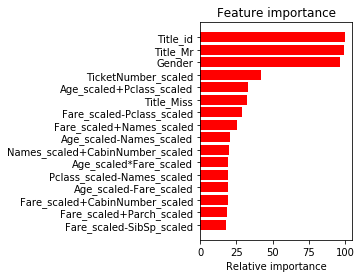


训练所使用的特征大小 16 特征分别是:
 ['Title_id' 'Title_Mr' 'Gender' 'TicketNumber_scaled'
 'Age_scaled+Pclass_scaled' 'Title_Miss' 'Fare_scaled-Pclass_scaled'
 'Fare_scaled+Names_scaled' 'Age_scaled-Names_scaled'
 'Names_scaled+CabinNumber_scaled' 'Age_scaled*Fare_scaled'
 'Pclass_scaled-Names_scaled' 'Age_scaled-Fare_scaled'
 'Fare_scaled+CabinNumber_scaled' 'Fare_scaled+Parch_scaled'
 'Fare_scaled-SibSp_scaled']
Generating RandomForestClassifier model with parameters:  {'min_samples_split': 13, 'n_estimators': 10000, 'max_features': 4}
OOB: 0.845117845118
OOB: 0.845117845118
OOB: 0.842873176207
OOB: 0.842873176207
OOB: 0.843995510662
oob mean:0.844
分类器准确将袋外样本分类正确的个数: 752.0
开始预测测试样本并提交------


ValueError: incomplete format

In [146]:
modelPredict()

In [148]:
result = pd.DataFrame({'PassengerId': submit_ids.as_matrix(), 'Survived': submission})

result.to_csv('randomforest_result.csv')


print("Finish Successfuly!!\n")

Finish Successfuly!!



In [134]:
X.shape

(891, 13)

In [139]:
submission = forest.predict(sumbit_x)

In [143]:
submission = submission.astype(int)

In [151]:
X.shape

(891, 13)

In [153]:
plot_learning_curve(forest,'forest',X,y)

KeyboardInterrupt: 

In [154]:
def plot_learning_curve(estimator,title, X, y,ylim=(0.8, 1.01), cv=None,
                        train_sizes=np.linspace(.05, 0.2, 5)):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    """
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on")
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

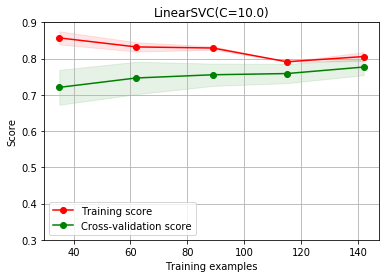

In [156]:
from sklearn.svm import LinearSVC
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.3, 0.9),
                    train_sizes=np.linspace(.05, 0.2, 5))